# Assignment 2: Cost-Aware A/B Testing

## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

## Problem and Task

**Problem Statement**: 

Formally, consider an experiment with $k$ treatment options $\{T_1, \ldots, T_k\}$ (no need to explicitly differentiate between treatment and control in a traditional sense, one of these options could be a control condition). Each of the $k$ treatments has a true underlying treatment effect $\{TE_1, \ldots, TE_k\}$, which is unknown to the experimenter before the experiment is conducted. For an arbitrary subject $i$ that is assigned to a treatment $j$, the realized treatment effect $TE_{ij}$ is a random draw from the normal distribution surrounding the true treatment effect with unknown variance, i.e., $TE_{ij} \sim N(TE_j, \sigma^2_j)$. There are $N$ subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: (1) the experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place); (2) at the same time, the experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

**Your Task**:
1. Formulate the above problem into a specific reinforcement learning problem. Clearly define and articulate the agent, environment, actions, rewards, and the agent's objective, etc.;
2. Create a simulation environment for this problem. This means manually picking some values for the treatment effects, number of subjects, and how the realized treatment effect for each subject should be generated, etc.;
3. Solve the reinforcement learning problem you have formulated in step 1 using multiple methods that may be appropriate. For each method that you choose to use, you need to (1) briefly describe how it works, (2) implement it, and (3) evaluate its performance in the simulation environment that you have created in step 2.
4. **Deliverable**: a PDF file rendered from a Jupyter Notebook that documents your answers, code, and outputs.

## Grading

Your grade for this assignment is determined by three factors:
1. Problem formulation (8 points): correctly formulate the problem and define its key components;
2. Simulation setup (2 points): correctly set up a decent simulation environment;
3. Solution (15 points): correctly describe, implement, and evaluate multiple solution methods. While only trying a single method is not sufficient, you also don't need to try too many (3-4 should be good).

# Answer:

## Problem formulation:

1. agent: the decision-maker who assign people to treatment and control groups
2. environment: everything outside the agent, such as treatment and control groups, N subjects, and perhalps the context of this experiment
3. actions: constantly assign a subject to a spcific group 
4. rewards: positive rewards if assign subject to a group that can avoid incurring too much costs
5. agent's objective: test the effectiveness of each treatment option while avoid incurring too much costs 

## Set up a decent simulation environment: 

Suppose we have a  10 treatment options, and the options are indexed by  {1,…,10} . Each option  𝑖  has a true expected reward that does not change over time, which we call  𝑟𝑖 , and the realized reward every time it is pulled follows a normal distribution  𝑁(𝑟𝑖,𝜎2𝑖) . The true expected reward and its variance are unknown.

The agent, at each round  𝑡 , will choose one of the  𝑘  options to pull. We denote the agent's action as  𝐴𝑡 , which is simply the index of an option. The agent receives reward  𝑅𝑡+1  as a result.

In [161]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

k = 10
N = 1000

np.random.seed(1234)
true_rewards = np.random.normal(size = k)

variance = np.random.randint(low = 1, high = 10, size = 10)

def pull(arm_ind):
    return np.random.normal(loc = true_rewards[arm_ind], scale = variance[arm_ind])

# Example, assign subject to the third treatment group
pull(2)

5.040415289491727

## Solution: common code

In [162]:
def value_est(curr_values, counter, action, reward):
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    counter[action] += 1
    return curr_values, counter

In [163]:
# Baseline: random pick
reward_random = []
sumreward_random = []
avereward_random = []
abtest = []

for t in range(N):
    arm = np.random.randint(low = 0, high = 10)
    reward = pull(arm)
    abtest.append([arm,reward])
    reward_random.append(reward)
    sumreward_random.append(np.sum(reward_random))
    avereward_random.append(np.mean(reward_random))

## Solution 1: greedy approach with optimistic initialization

1. pick the best option so far
2. initialize the value of each action to a somewhat large positive number. This way, an options that's not tried before may appear more attractive.

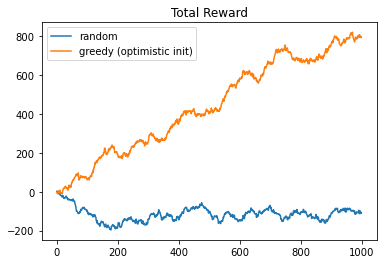

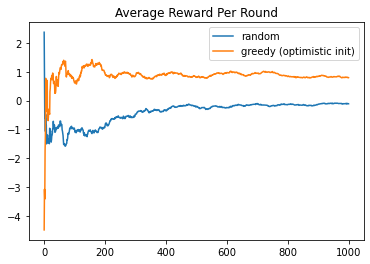

In [164]:
# Greedy strategy with optimistic initialization
curr_values = [4]*k 
counter = [0]*k  
reward_greedy_optint = []
sumreward_greedy_optint = []
avereward_greedy_optint = []
abtest_1 = []

for n in range(N):
    arm = np.argmax(curr_values)
    reward = pull(arm)
    abtest_1.append([arm,reward])
    reward_greedy_optint.append(reward)
    sumreward_greedy_optint.append(np.sum(reward_greedy_optint))
    avereward_greedy_optint.append(np.mean(reward_greedy_optint))
    curr_values, counter = value_est(curr_values, counter, arm, reward)

plt.plot(sumreward_random)
plt.plot(sumreward_greedy_optint)
plt.title("Total Reward")
plt.legend(["random", "greedy (optimistic init)"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy_optint)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy (optimistic init)"])
plt.show()

## Solution 2: Epsilon-Greedy strategy

1. "force" the greedy algorithm to explore once in a while

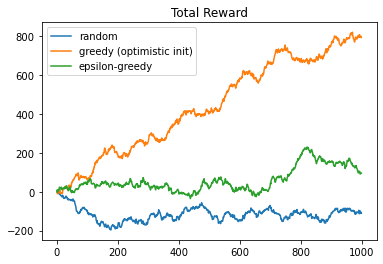

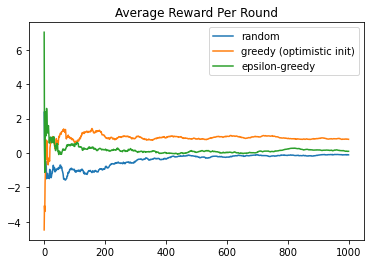

In [165]:
# Epsilon-Greedy strategy
curr_values = [0]*k  
counter = [0]*k 
eps = 0.4
reward_greedy_eps = []
sumreward_greedy_eps = []
avereward_greedy_eps = []
abtest_2 = []

for n in range(N):
    arm = np.argmax(curr_values)
    explore = np.random.binomial(1, eps)
    if explore:
        arm = np.random.choice(np.setdiff1d(range(k), arm))
    reward = pull(arm)
    abtest_2.append([arm,reward])
    reward_greedy_eps.append(reward)
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))
    curr_values, counter = value_est(curr_values, counter, arm, reward)

plt.plot(sumreward_random)
plt.plot(sumreward_greedy_optint)
plt.plot(sumreward_greedy_eps)
plt.title("Total Reward")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy_optint)
plt.plot(avereward_greedy_eps)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

## Solution 3: Upper-Confidence-Bound (UCB) Strategy

1. strategically explore the actions that are under-explored

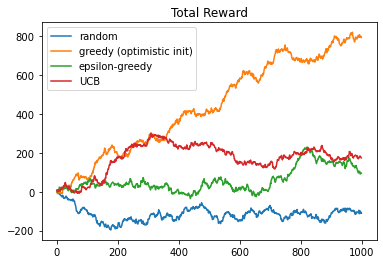

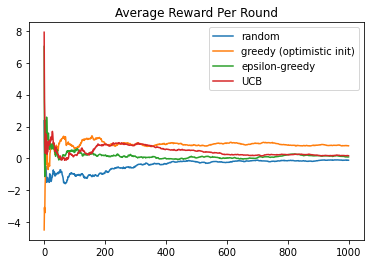

In [166]:
# UCB

def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99   
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values


curr_values = [0]*k  
counter = [0]*k  
c = 10  #c = 10.0  very aggressive exploration
reward_ucb = []
sumreward_ucb = []
avereward_ucb = []
abtest_3 = []
for n in range(N):
    ucb_values = ucb_calc(curr_values, t+1, counter, c)
    arm = np.argmax(ucb_values)    
    reward = pull(arm)
    abtest_3.append([arm,reward])
    reward_ucb.append(reward)
    sumreward_ucb.append(np.sum(reward_ucb))
    avereward_ucb.append(np.mean(reward_ucb))
    curr_values, counter = value_est(curr_values, counter, arm, reward)

plt.plot(sumreward_random)
plt.plot(sumreward_greedy_optint)
plt.plot(sumreward_greedy_eps)
plt.plot(sumreward_ucb)
plt.title("Total Reward")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", "UCB"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy_optint)
plt.plot(avereward_greedy_eps)
plt.plot(avereward_ucb)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", "UCB"])
plt.show()

## Adjustment and Evaluation: 

In [169]:
optimistic_initialization = pd.DataFrame({'Group':[item[0] for item in abtest_1],'Effect':[item[1] for item in abtest_1]})
optimistic_initialization

,Group,Effect
0,0,-4.475336
1,1,-1.660735
2,2,-4.089897
3,3,3.315911
4,4,0.854551
...,...,...
995,5,2.445095
996,5,-3.655972
997,5,5.578408
998,5,-1.475510


In [168]:
Epsilon = pd.DataFrame({'Group':[item[0] for item in abtest_2],'Effect':[item[1] for item in abtest_2]})
Epsilon

,Group,Effect
0,0,7.016709
1,7,-5.078684
2,0,-5.332876
3,5,12.957045
4,5,-4.895113
...,...,...
995,9,-12.441994
996,5,0.296514
997,0,0.327330
998,0,2.695336


In [160]:
UCB = pd.DataFrame({'Group':[item[0] for item in abtest_3],'Effect':[item[1] for item in abtest_3]})
UCB

,Group,Effect
0,0,-3.391163
1,1,-0.436535
2,2,1.328687
3,3,-1.164366
4,4,-1.863571
...,...,...
995,0,-2.607242
996,9,-8.665013
997,6,4.015402
998,6,1.719524


## Adjustment: 
1. the variance of each treatment effect is picked randomly from a normal distribution so as to satisfy the unknown variance requirement
2. a list is created to store the assigned treatment group number and treatment effect values; in this way, we can store the treatment effect information and calcuate mean and standard deviations using these data to satisfy the main objective of AB Testing

## Evaluatation:
1. both three methods are much better than random pick
2. greedy with optimistic initiation have better rewards thus lower cost but it doesn't explore too many times, so it may hamper the AB testing validity
3. episilon greedy and UCB have similar cost and they explored many options, so they satisfy the AB testing requirements and also reduce the cost